In [24]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import itertools
import random
import librosa

In [25]:
mnist = tf.keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = X_train/255
X_test = X_test/255

# Network Compression Using SVD

In [26]:
model_baseline = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(1024, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.Dense(1024, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.Dense(1024, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.Dense(1024, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.Dense(1024, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
model_baseline.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
Accuracy_baseline = model_baseline.fit(X_train, Y_train, epochs=100, batch_size=128, validation_data=(X_test, Y_test))

In [37]:
[W0, B0] = model_baseline.layers[1].get_weights()
[W1, B1] = model_baseline.layers[2].get_weights()
[W2, B2] = model_baseline.layers[3].get_weights()
[W3, B3] = model_baseline.layers[4].get_weights()
[W4, B4] = model_baseline.layers[5].get_weights()
[W5, B5] = model_baseline.layers[6].get_weights()

In [38]:
S0, U0, V0 = tf.linalg.svd(W0)
S1, U1, V1 = tf.linalg.svd(W1)
S2, U2, V2 = tf.linalg.svd(W2)
S3, U3, V3 = tf.linalg.svd(W3)
S4, U4, V4 = tf.linalg.svd(W4)

In [39]:
def compressedWeights(D, U, S, V, W):
    U = U[:,0:D]
    S = tf.linalg.diag(S[0:D])
    V = V[:,0:D]
    return np.matmul(U, np.matmul(S, tf.transpose(V)))

In [40]:
def accuracyD(D, 
    U0, S0, V0, W0, B0, 
    U1, S1, V1, W1, B1, 
    U2, S2, V2, W2, B2, 
    U3, S3, V3, W3, B3, 
    U4, S4, V4, W4, B4):
    
    W0_D = compressedWeights(D, U0, S0, V0, W0)
    W1_D = compressedWeights(D, U1, S1, V1, W1)
    W2_D = compressedWeights(D, U2, S2, V2, W2)
    W3_D = compressedWeights(D, U3, S3, V3, W3)
    W4_D = compressedWeights(D, U4, S4, V4, W4)
    
    model_baseline.layers[1].set_weights([W0_D, B0])
    model_baseline.layers[2].set_weights([W1_D, B1])
    model_baseline.layers[3].set_weights([W2_D, B2])
    model_baseline.layers[4].set_weights([W3_D, B3])
    model_baseline.layers[5].set_weights([W4_D, B4])

    Accuracy_D = model_baseline.evaluate(X_test, Y_test, verbose=1)[1]
    
    return Accuracy_D

In [37]:
# Accuracy for D = 10, 20, 50, 100, 200
A10 = accuracyD(10, U0, S0, V0, W0, B0, U1, S1, V1, W1, B1, U2, S2, V2, W2, B2, U3, S3, V3, W3, B3, U4, S4, V4, W4, B4)
A20 = accuracyD(20, U0, S0, V0, W0, B0, U1, S1, V1, W1, B1, U2, S2, V2, W2, B2, U3, S3, V3, W3, B3, U4, S4, V4, W4, B4)
A50 = accuracyD(50, U0, S0, V0, W0, B0, U1, S1, V1, W1, B1, U2, S2, V2, W2, B2, U3, S3, V3, W3, B3, U4, S4, V4, W4, B4)
A100 = accuracyD(100, U0, S0, V0, W0, B0, U1, S1, V1, W1, B1, U2, S2, V2, W2, B2, U3, S3, V3, W3, B3, U4, S4, V4, W4, B4)
A200 = accuracyD(200, U0, S0, V0, W0, B0, U1, S1, V1, W1, B1, U2, S2, V2, W2, B2, U3, S3, V3, W3, B3, U4, S4, V4, W4, B4)

# Accuracy for D_Full 
W0_D = compressedWeights(784, U0, S0, V0, W0)
W1_D = compressedWeights(1024, U1, S1, V1, W1)
W2_D = compressedWeights(1024, U2, S2, V2, W2)
W3_D = compressedWeights(1024, U3, S3, V3, W3)
W4_D = compressedWeights(1024, U4, S4, V4, W4)
    
model_baseline.layers[1].set_weights([W0_D, B0])
model_baseline.layers[2].set_weights([W1_D, B1])
model_baseline.layers[3].set_weights([W2_D, B2])
model_baseline.layers[4].set_weights([W3_D, B3])
model_baseline.layers[5].set_weights([W4_D, B4])

Afull = model_baseline.evaluate(X_test, Y_test, verbose=1)[1]

313/313 [==============================] - 1s 3ms/step - loss: 0.1338 - accuracy: 0.9842


Text(0, 0.5, 'Test Accuracy')

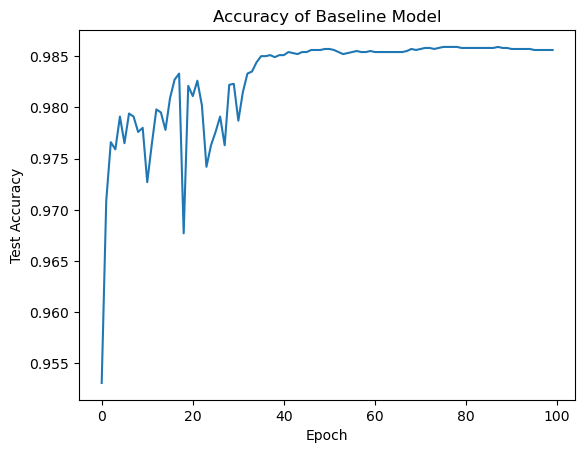

In [42]:
accub = Accuracy_baseline.history['val_accuracy']

plt.figure()
plt.plot(accub)
plt.title('Accuracy of Baseline Model')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')

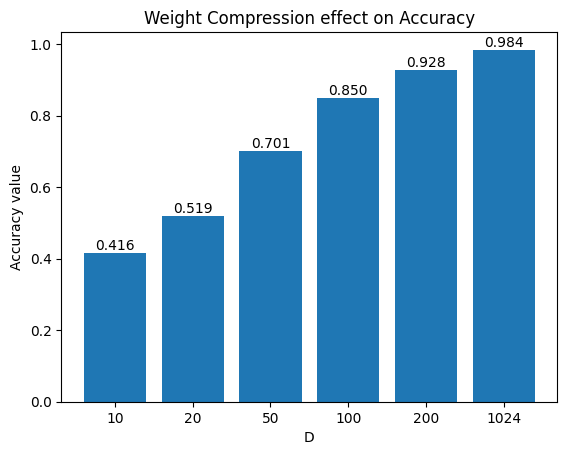

In [53]:
D = [10, 20, 50, 100, 200, 1024]
y = [A10, A20, A50, A100, A200, Afull]
plt.figure()
plt.bar(range(len(D)), y)
plt.xticks(range(len(D)), D)
plt.xlabel('D')
plt.ylabel('Accuracy value')
plt.title('Weight Compression effect on Accuracy')
for i, height in enumerate(y):
    plt.text(i, height, '{:.3f}'.format(height), ha='center', va='bottom')


In [27]:
trainable_params = int(sum([tf.reduce_prod(w.shape) for w in model_baseline.trainable_variables]))
print("Number of trainable parameters:", trainable_params)

Number of trainable parameters: 5012490


In [28]:
def compressesParameterCount(D):
    return (784*D) + (D*1024) + (4*(1024*D)) + (4*(D*1024)) + (1024*10) 

In [29]:
P10 = compressesParameterCount(10)
P20 = compressesParameterCount(20)
P50 = compressesParameterCount(50)
P100 = compressesParameterCount(100)
P200 = compressesParameterCount(200)

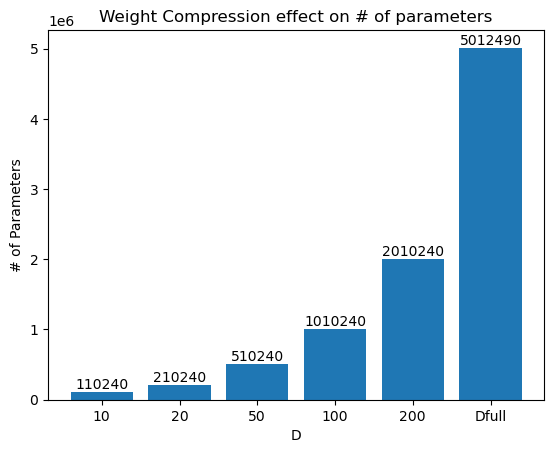

In [35]:
# D = [10, 20, 50, 100, 200, 1024]
D = ['10', '20', '50', '100', '200', 'Dfull']
y = [P10, P20, P50, P100, P200, trainable_params]
plt.figure()
plt.bar(range(len(D)), y)
plt.xticks(range(len(D)), D)
plt.xlabel('D')
plt.ylabel('# of Parameters')
plt.title('Weight Compression effect on # of parameters')
for i, height in enumerate(y):
    plt.text(i, height, '{:.0f}'.format(height), ha='center', va='bottom')

As we compress the network, the count of trainable parameters decreases. The extent of this reduction depends on the value of D: a lower D results in more significant compression and fewer parameters to store in memory. However, this reduction comes with a trade-off, as the accuracy tends to decrease compared to the baseline model.

Nonetheless, there exists an optimal compression value, D, which decreases the parameter count while maintaining comparable accuracy. In our specific scenario, when D is set to 200, the accuracy remains around 92%, while the number of parameters is reduced to only one-third of what the baseline model has.

# Part 2

A new network is defined whose weight matrices W(l) are factorized. In this new network, W(l) is not estimated directly anymore, but its factor matrices, to reconstruct $W^{(l)}$ as follows: $$W^{(l)} = U^{(l)}V^{(l)^⊤}$$

Here it is to be noted that $U$ and $V$ are the new variables to be estimate via optimization.

In [43]:
class factorizedWeightLayer(tf.keras.layers.Layer):
    def __init__(self, out_dim, U_init, S_init, V_init, B_init):
        super(factorizedWeightLayer, self).__init__()
        self.out_dim = out_dim
        self.U_init = U_init
        self.S_init = S_init
        self.V_init = V_init
        self.B_init = B_init
    
    def build(self, input_shape):
        # print(input_shape.shape)
        VT_init = np.matmul(self.S_init, tf.transpose(self.V_init))
        self.U = self.add_weight(shape=(input_shape[-1], 20),
                                 initializer=tf.keras.initializers.Constant(self.U_init),
                                 trainable=True)
        self.VT = self.add_weight(shape=(20, self.out_dim),
                                  initializer=tf.keras.initializers.Constant(VT_init),
                                  trainable=True)
        self.bias = self.add_weight(shape=(self.out_dim),
                                    initializer=tf.keras.initializers.Constant(self.B_init),
                                    trainable=True)
        
    def call(self, inputs):
        W = tf.matmul(self.U, self.VT)
        result = tf.nn.relu(tf.matmul(inputs, W) + self.bias)
        return result

In [114]:
# Model with factorized weight matrix 
D = 20
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    factorizedWeightLayer(1024, U0[:,0:D], tf.linalg.diag(S0[0:D]), V0[:,0:D], B0),
    factorizedWeightLayer(1024, U1[:,0:D], tf.linalg.diag(S1[0:D]), V1[:,0:D], B1),
    factorizedWeightLayer(1024, U2[:,0:D], tf.linalg.diag(S2[0:D]), V2[:,0:D], B2),
    factorizedWeightLayer(1024, U3[:,0:D], tf.linalg.diag(S3[0:D]), V3[:,0:D], B3),
    factorizedWeightLayer(1024, U4[:,0:D], tf.linalg.diag(S4[0:D]), V4[:,0:D], B4),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
Accuracy = model.fit(X_train, Y_train, epochs=200, batch_size=128, validation_data=(X_test, Y_test))

Text(0, 0.5, 'Test Accuracy')

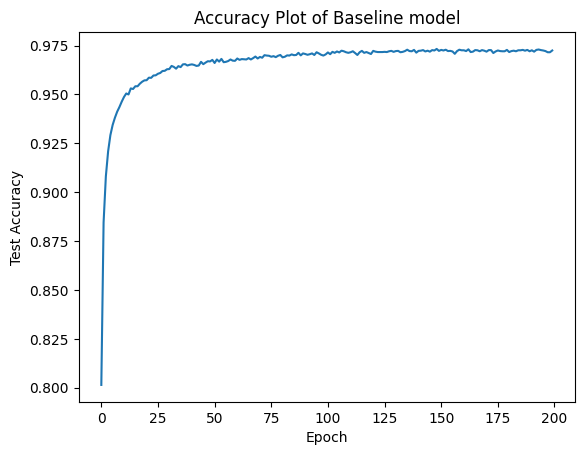

In [116]:
accu = Accuracy.history['val_accuracy']

plt.figure()
plt.plot(accu)
plt.title('Accuracy Plot')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')

# Part 3

This time, for the feedforward pass, $W^{(l)}$ is not used. Instead, at every iteration SVD is performed.

In [44]:
class factorizedWeightSVD(tf.keras.layers.Layer):
    def __init__(self, out_dim, W_init, B_init):
        super(factorizedWeightSVD, self).__init__()
        self.out_dim = out_dim
        self.W_init = W_init
        self.B_init = B_init
    
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], self.out_dim),
                                 initializer=tf.keras.initializers.Constant(self.W_init),
                                 trainable=True)

        self.bias = self.add_weight(shape=(self.out_dim),
                                    initializer=tf.keras.initializers.Constant(self.B_init),
                                    trainable=True)
        
    def call(self, inputs):
        D = 20
        S, U, V = tf.linalg.svd(self.W)
        U = U[:,0:D]
        S = tf.linalg.diag(S[0:D])
        V = V[:,0:D]
        W = tf.matmul(U, tf.matmul(S, tf.transpose(V)))
        result = tf.nn.relu(tf.matmul(inputs, W) + self.bias)
        return result

In [45]:
# Model with factorized weight matrix 

model_SVD = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    factorizedWeightSVD(1024, W0, B0),
    factorizedWeightSVD(1024, W1, B1),
    factorizedWeightSVD(1024, W2, B2),
    factorizedWeightSVD(1024, W3, B3),
    factorizedWeightSVD(1024, W4, B4),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001)
model_SVD.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
Accuracy_SVD = model_SVD.fit(X_train, Y_train, epochs=100, batch_size=128, validation_data=(X_test, Y_test))

Text(0, 0.5, 'Test Accuracy')

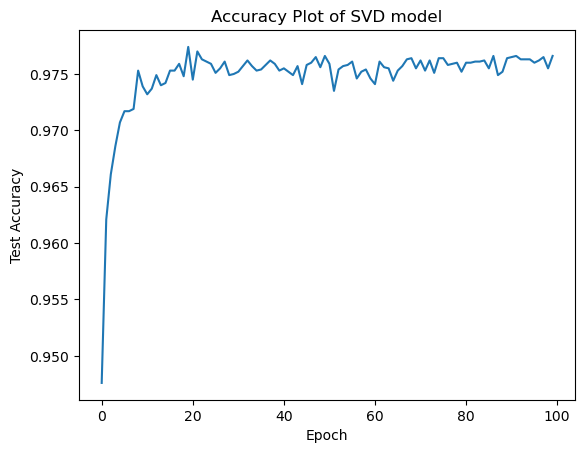

In [47]:
accu_SVD = Accuracy_SVD.history['val_accuracy']

plt.figure()
plt.plot(accu_SVD)
plt.title('Accuracy Plot of SVD model')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')

# Question 4

In [15]:
with open('trs.pkl', 'rb') as file:
    trs_old = pickle.load(file)
    
with open('tes.pkl', 'rb') as file:
    tes = pickle.load(file)

trs = np.zeros((500, 22631))
trs[:, :trs_old.shape[1]] = trs_old
print(trs.shape)
print(tes.shape)

(500, 22631)
(200, 22631)


In [16]:
def PMatrix(trs, speaker):
    a = speaker*10
    b = speaker*10+10
    combinations = list(itertools.combinations(range(a, b), 2))
    p_matrix = []
    for i in range(len(combinations)):
        p = tf.concat([trs[combinations[i][0], :], trs[combinations[i][1], :]], axis=0)
        p_matrix.append(p)

    return tf.stack(p_matrix)

In [17]:
def NMatrix(trs, speaker, N):
    a = speaker*10
    b = speaker*10+10
    range1 = range(a, b)
    range2 = [x for x in range(N) if x < a or x > b]

    combinations = list(itertools.product(range1, range2))
    n_matrix = []
    for i in range(45):
        combination = random.choice(combinations)
        n = tf.concat([trs[combination[0], :], trs[combination[1], :]], axis=0)
        n_matrix.append(n)
    
    return tf.stack(n_matrix)

In [18]:
matrix_train = []
for speaker in range(50):
    p_matrix = PMatrix(trs, speaker)
    n_matrix = NMatrix(trs, speaker, 500)
    
    matrix_train.append(np.concatenate((p_matrix, n_matrix), axis=0))

matrix_train = tf.stack(matrix_train)
print(matrix_train.shape)

matrix_test = []
for speaker in range(20):
    p_matrix = PMatrix(tes, speaker)
    n_matrix = NMatrix(tes, speaker, 200)
    
    matrix_test.append(np.concatenate((p_matrix, n_matrix), axis=0))

matrix_test = tf.stack(matrix_test)
print(matrix_test.shape)

(50, 90, 45262)
(20, 90, 45262)


In [19]:
X_train_matrix = np.reshape(matrix_train, (50 * 90, 2, 1, 22631))
print(X_train_matrix.shape)

X_test_matrix = np.reshape(matrix_test, (20 * 90, 2, 1, 22631)) #22631
print(X_test_matrix.shape)

(4500, 2, 1, 22631)
(1800, 2, 1, 22631)


In [20]:
X_train_matrix  = tf.reshape(X_train_matrix, (4500, 2, 22631))
stft_data_train = tf.signal.stft(X_train_matrix , frame_length=1024, frame_step=512)
stft_data_train = tf.abs(stft_data_train)

X_test_matrix  = tf.reshape(X_test_matrix, (1800, 2,22631)) #22631
stft_data_test = tf.signal.stft(X_test_matrix , frame_length=1024, frame_step=512)
stft_data_test = tf.abs(stft_data_test)

In [21]:
positive_labels = np.ones((45,))
negative_labels = np.zeros((45,))
labels_train = np.tile(np.concatenate([positive_labels, negative_labels]), 50)
labels_test = np.tile(np.concatenate([positive_labels, negative_labels]), 20)

In [22]:
shared_network = tf.keras.Sequential()
shared_network.add(tf.keras.layers.GRU(513, return_sequences=True))
shared_network.add(tf.keras.layers.Dropout(rate = 0.2))
shared_network.add(tf.keras.layers.GRU(513, return_sequences=False))
# shared_network.add(tf.keras.layers.Dropout(rate = 0.2))
# shared_network.add(tf.keras.layers.Dense(50, activation = 'relu'))

sound_A_input = tf.keras.layers.Input((43, 513), name='sound_A')
sound_B_input = tf.keras.layers.Input((43, 513), name='sound_B')

feature_vector_A = shared_network(sound_A_input)
feature_vector_B = shared_network(sound_B_input)

dot_product = tf.matmul(feature_vector_A, tf.transpose(feature_vector_B))
vect = tf.linalg.diag_part(dot_product)
output = tf.keras.layers.Activation('sigmoid')(vect)
output = tf.reshape(output, [-1, 1])

siamese_model = tf.keras.models.Model(inputs=[sound_A_input, sound_B_input], outputs=output)

In [ ]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
siamese_model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.BinaryAccuracy()])
Accuracy_siamese = siamese_model.fit([stft_data_train[:,0,:,:], stft_data_train[:,1,:,:]], labels_train, 
                                     epochs=70, batch_size=90,
                                     validation_data=([stft_data_test[:,0,:,:], stft_data_test[:,1,:,:]], labels_test))

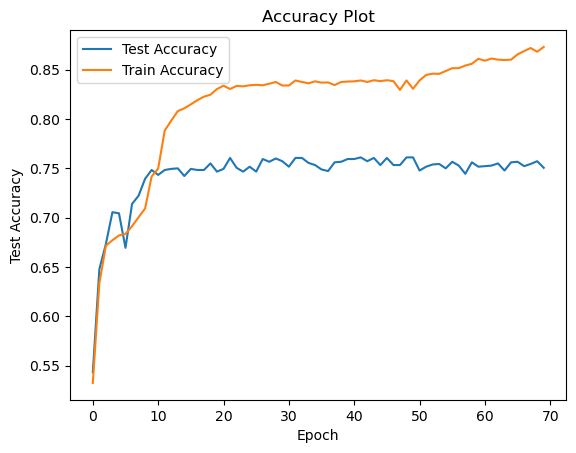

In [29]:
accu = Accuracy_siamese.history['val_binary_accuracy']
accu_train = Accuracy_siamese.history['binary_accuracy']
plt.figure()
plt.plot(accu, label='Test Accuracy')
plt.plot(accu_train, label='Train Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()

# Question 5

## Train Data

In [3]:
directory = 'timit-homework/tr/'

trn = []
max_col = 0

for i in range(1200):
    filename = f'trn{i:04d}.wav' 
    file_path = directory + filename 
    audio_data, sr = librosa.load(file_path, sr=None)
    
    stft_data = librosa.stft(audio_data, n_fft=1024, hop_length=512)
    magnitude_data = np.abs(stft_data)
    
    trn.append(magnitude_data)
    
    if max_col < len(magnitude_data[0]):
        max_col = len(magnitude_data[0])

padded_trn = []
for magnitude_data in trn:
    num_columns = len(magnitude_data[0])
    if num_columns < max_col:
        pad_width = max_col - num_columns
        magnitude_data = np.pad(magnitude_data, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
    
    padded_trn.append(magnitude_data)

padded_trn = tf.stack(padded_trn)
padded_trn = np.transpose(padded_trn, (0, 2, 1))
print(padded_trn.shape)

(1200, 178, 513)


In [4]:
directory = 'timit-homework/tr/'

trx = []
X_cmplx = []
max_col = 0

for i in range(1200):
    filename = f'trx{i:04d}.wav' 
    file_path = directory + filename 
    audio_data, sr = librosa.load(file_path, sr=None)
    
    stft_data = librosa.stft(audio_data, n_fft=1024, hop_length=512)
    magnitude_data = np.abs(stft_data)
    X_cmplx.append(stft_data)
    trx.append(magnitude_data)
    
    if max_col < len(magnitude_data[0]):
        max_col = len(magnitude_data[0])

padded_trx = []
for magnitude_data in trx:
    num_columns = len(magnitude_data[0])
    if num_columns < max_col:
        pad_width = max_col - num_columns
        magnitude_data = np.pad(magnitude_data, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
    
    padded_trx.append(magnitude_data)

padded_X_cmplx = []
for stft_data in X_cmplx:
    num_columns = len(stft_data[0])
    if num_columns < max_col:
        pad_width = max_col - num_columns
        stft_data = np.pad(stft_data, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
    
    padded_X_cmplx.append(stft_data)

padded_trx = tf.stack(padded_trx)
padded_trx = np.transpose(padded_trx, (0, 2, 1))
print(padded_trx.shape)

padded_X_cmplx = tf.stack(padded_X_cmplx)
padded_X_cmplx = np.transpose(padded_X_cmplx, (0, 2, 1))
print(padded_X_cmplx.shape)

(1200, 178, 513)
(1200, 178, 513)


In [5]:
directory = 'timit-homework/tr/'

trs = []
max_col = 0

for i in range(1200):
    filename = f'trs{i:04d}.wav' 
    file_path = directory + filename 
    audio_data, sr = librosa.load(file_path, sr=None)
    
    stft_data = librosa.stft(audio_data, n_fft=1024, hop_length=512)
    magnitude_data = np.abs(stft_data)
    
    trs.append(magnitude_data)
    
    if max_col < len(magnitude_data[0]):
        max_col = len(magnitude_data[0])

padded_trs = []
for magnitude_data in trs:
    num_columns = len(magnitude_data[0])
    if num_columns < max_col:
        pad_width = max_col - num_columns
        magnitude_data = np.pad(magnitude_data, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
    
    padded_trs.append(magnitude_data)

padded_trs = tf.stack(padded_trs)
padded_trs = np.transpose(padded_trs, (0, 2, 1))
print(padded_trs.shape)

(1200, 178, 513)


## Validation Data

In [6]:
directory = 'timit-homework/v/'

vs = []
vs1 = []
max_col = 0
max_col1 = 0

for i in range(1200):
    filename = f'vs{i:04d}.wav' 
    file_path = directory + filename 
    audio_data, sr = librosa.load(file_path, sr=None)
    
    stft_data = librosa.stft(audio_data, n_fft=1024, hop_length=512)
    magnitude_data = np.abs(stft_data)
    
    vs.append(audio_data)
    vs1.append(magnitude_data)
    
    if max_col < len(audio_data):
        max_col = len(audio_data)
    
    if max_col1 < len(magnitude_data[0]):
        max_col1 = len(magnitude_data[0])

padded_vs = []
for audio_data in vs:
    num_columns = len(audio_data)
    if num_columns < max_col:
        pad_width = max_col - num_columns
        audio_data = np.pad(audio_data, (0, pad_width), mode='constant', constant_values=0)
    
    padded_vs.append(audio_data)

padded_vs = tf.stack(padded_vs)
print(padded_vs.shape)

padded_vs1 = []
for magnitude_data in vs1:
    num_columns = len(magnitude_data[0])
    if num_columns < max_col1:
        pad_width = max_col1 - num_columns
        magnitude_data = np.pad(magnitude_data, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
    
    padded_vs1.append(magnitude_data)

padded_vs1 = tf.stack(padded_vs1)
padded_vs1 = np.transpose(padded_vs1, (0, 2, 1))
print(padded_vs1.shape)


(1200, 90727)
(1200, 178, 513)


In [7]:
directory = 'timit-homework/v/'

vn = []
max_col = 0

for i in range(1200):
    filename = f'vn{i:04d}.wav' 
    file_path = directory + filename 
    audio_data, sr = librosa.load(file_path, sr=None)
    
    stft_data = librosa.stft(audio_data, n_fft=1024, hop_length=512)
    magnitude_data = np.abs(stft_data)
    
    vn.append(magnitude_data)
    
    if max_col < len(magnitude_data[0]):
        max_col = len(magnitude_data[0])

padded_vn = []
for magnitude_data in vn:
    num_columns = len(magnitude_data[0])
    if num_columns < max_col:
        pad_width = max_col - num_columns
        magnitude_data = np.pad(magnitude_data, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
    
    padded_vn.append(magnitude_data)

padded_vn = tf.stack(padded_vn)
padded_vn = np.transpose(padded_vn, (0, 2, 1))
print(padded_vn.shape)

(1200, 178, 513)


In [8]:
directory = 'timit-homework/v/'

vx = []
VX_cmplx = []
max_col = 0

for i in range(1200):
    filename = f'vx{i:04d}.wav' 
    file_path = directory + filename 
    audio_data, sr = librosa.load(file_path, sr=None)
    
    stft_data = librosa.stft(audio_data, n_fft=1024, hop_length=512)
    magnitude_data = np.abs(stft_data)
    VX_cmplx.append(stft_data)
    vx.append(magnitude_data)
    
    if max_col < len(magnitude_data[0]):
        max_col = len(magnitude_data[0])

padded_vx = []
for magnitude_data in vx:
    num_columns = len(magnitude_data[0])
    if num_columns < max_col:
        pad_width = max_col - num_columns
        magnitude_data = np.pad(magnitude_data, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
    
    padded_vx.append(magnitude_data)

padded_VX_cmplx = []
for stft_data in VX_cmplx:
    num_columns = len(stft_data[0])
    if num_columns < max_col:
        pad_width = max_col - num_columns
        stft_data = np.pad(stft_data, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
    
    padded_VX_cmplx.append(stft_data)

padded_vx = tf.stack(padded_vx)
padded_vx  = np.transpose(padded_vx, (0, 2, 1))
print(padded_vx.shape)

padded_VX_cmplx = tf.stack(padded_VX_cmplx)
padded_VX_cmplx = np.transpose(padded_VX_cmplx, (0, 2, 1))
print(padded_VX_cmplx.shape)

(1200, 178, 513)
(1200, 178, 513)


## Test Data

In [95]:
directory = 'timit-homework/te/'

tex = []
TEX_cmplx = []
max_col = 0

for i in range(400):
    filename = f'tex{i:04d}.wav' 
    file_path = directory + filename 
    audio_data, sr = librosa.load(file_path, sr=None)
    
    stft_data = librosa.stft(audio_data, n_fft=1024, hop_length=512)
    magnitude_data = np.abs(stft_data)
    TEX_cmplx.append(stft_data)
    tex.append(magnitude_data)
    
    if max_col < len(magnitude_data[0]):
        max_col = len(magnitude_data[0])

padded_tex = []
for magnitude_data in tex:
    num_columns = len(magnitude_data[0])
    if num_columns < max_col:
        pad_width = max_col - num_columns
        magnitude_data = np.pad(magnitude_data, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
    
    padded_tex.append(magnitude_data)

padded_TEX_cmplx = []
for stft_data in TEX_cmplx:
    num_columns = len(stft_data[0])
    if num_columns < max_col:
        pad_width = max_col - num_columns
        stft_data = np.pad(stft_data, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
    
    padded_TEX_cmplx.append(stft_data)

padded_tex = tf.stack(padded_tex)
padded_tex  = np.transpose(padded_tex, (0, 2, 1))
print(padded_tex.shape)

padded_TEX_cmplx = tf.stack(padded_TEX_cmplx)
padded_TEX_cmplx = np.transpose(padded_TEX_cmplx, (0, 2, 1))
print(padded_TEX_cmplx.shape)

(400, 195, 513)
(400, 195, 513)


## IBM Matrix

In [9]:
# trx is input to the RNN 
# trn and trs are used to create the trarget M 
# shape of trx 1200, 513, 178
# shape of target is 1200, 513, 178

M_matrix =[]
for i in range(1200):
    A = padded_trs[i]
    B = padded_trn[i]
    M = tf.cast(tf.greater(A, B), dtype=tf.int32)
    M_matrix.append(M)

M_matrix = tf.stack(M_matrix)
print(M_matrix.shape)

(1200, 178, 513)


In [10]:
# for validation

V_M_matrix =[]
for i in range(1200):
    A = padded_vs1[i]
    B = padded_vn[i]
    M = tf.cast(tf.greater(A, B), dtype=tf.int32)
    V_M_matrix.append(M)

V_M_matrix = tf.stack(V_M_matrix)
print(V_M_matrix.shape)

(1200, 178, 513)


## Training Model 

In [11]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(513, return_sequences=True, activation='relu'))
model.add(tf.keras.layers.Dropout(rate = 0.2))
model.add(tf.keras.layers.GRU(513, return_sequences=True, activation='relu'))
model.add(tf.keras.layers.Dropout(rate = 0.2))
model.add(tf.keras.layers.Dense(513, activation='sigmoid'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='binary_crossentropy')
Accuracy_model = model.fit(padded_trx, M_matrix, 
                           epochs=100, 
                           batch_size=10,
                           validation_data=(padded_vx, V_M_matrix))

Text(0, 0.5, 'Loss')

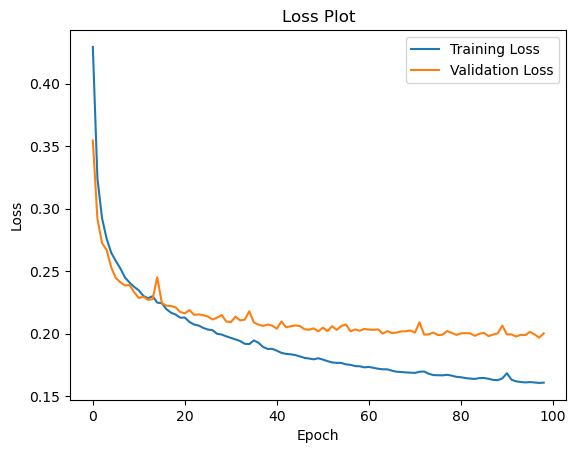

In [29]:
plt.figure()
plt.plot(Accuracy_model.history['loss'], label='Training Loss')
plt.plot(Accuracy_model.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [41]:
M_hat = model.predict(padded_vx, batch_size=10)   
S_hat =np.multiply(M_hat, padded_VX_cmplx)  
S_hat = np.transpose(S_hat, (0, 2, 1))
s_hat = librosa.istft(S_hat, win_length=1024, hop_length=512)
padded_vs = padded_vs[:, 0:len(s_hat[0])]

num = np.sum(np.square(padded_vs), axis=1)
den = np.sum(np.square(padded_vs - s_hat), axis=1)
snr = 10 * np.log10(num / den)
print('Average value of SNR is:', np.mean(snr))

120/120 [==============================] - 34s 281ms/step
Average value of SNR is: 11.469873


In [42]:
M_hat = model.predict(padded_tex, batch_size=10)   
S_hat =np.multiply(M_hat, padded_TEX_cmplx)  
S_hat = np.transpose(S_hat, (0, 2, 1))
s_hat = librosa.istft(S_hat, win_length=1024, hop_length=512)  

40/40 [==============================] - 13s 309ms/step


In [ ]:
directory = 'timit-homework/te/'
directory1 = 'timit-homework/te_hat/'

for i in range(400):
    filename = f'tex{i:04d}.wav' 
    file_path = directory + filename 
    s, sr = librosa.load(file_path, sr=None)
    s_hat_1 = s_hat[i][:len(s)]
    filename1 = f'tex_hat{i:04d}.wav' 
    file_path1 = directory1 + filename1 
    sf.write(file_path1, s_hat_1, sr)